# Phase 1 — Data Understanding & Sanity Checks

Before modeling, we must understand what the dataset represents, how it behaves over time, and whether it is structurally clean.

This phase ensures:
- data integrity
- correct data types
- no hidden leakage
- early detection of anomalies

---

In [4]:
# import all libraries 

# data analysis-libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# scikit-learn models and validation functions
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# metrics
from sklearn.metrics import root_mean_squared_error


## Dataset Overview

Each row represents **one hourly observation** of energy production.

Key characteristics:
- Time-indexed tabular data
- Continuous regression target (`Production`)
- Mixed feature types (numeric + categorical)
- Strong temporal dependency

We verify:
- dataset shape (rows × columns)
- column names
- preview of first and last rows (important in time series)

---

In [5]:
data = pd.read_csv("../data/Energy Production Dataset.csv",
                   parse_dates=["Date"])
data.head()

,Date,Start_Hour,End_Hour,Source,Day_of_Year,Day_Name,Month_Name,Season,Production
0,2025-11-30,21,22,Wind,334,Sunday,November,Fall,5281
1,2025-11-30,18,19,Wind,334,Sunday,November,Fall,3824
2,2025-11-30,16,17,Wind,334,Sunday,November,Fall,3824
3,2025-11-30,23,0,Wind,334,Sunday,November,Fall,6120
4,2025-11-30,6,7,Wind,334,Sunday,November,Fall,4387


In [6]:
data.tail()

,Date,Start_Hour,End_Hour,Source,Day_of_Year,Day_Name,Month_Name,Season,Production
51859,2020-01-01,4,5,Wind,1,Wednesday,January,Winter,2708
51860,2020-01-01,18,19,Wind,1,Wednesday,January,Winter,1077
51861,2020-01-01,7,8,Wind,1,Wednesday,January,Winter,2077
51862,2020-01-01,14,15,Solar,1,Wednesday,January,Winter,1783
51863,2020-01-01,13,14,Solar,1,Wednesday,January,Winter,2179


In [4]:
print("shape: ",data.shape)
print("\ndtype:\n",data.dtypes)

shape:  (51864, 9)

dtype:
 Date           datetime64[ns]
Start_Hour              int64
End_Hour                int64
Source                 object
Day_of_Year             int64
Day_Name               object
Month_Name             object
Season                 object
Production              int64
dtype: object




## Data Types Validation

Time series modeling requires strict type correctness.

Checks performed:
- `Date` converted to proper `datetime`
- `Production` confirmed numeric
- categorical variables (e.g., energy source, season) properly encoded as category/string
- no unintended object dtypes

Why this matters:
Improper types can silently break feature engineering, sorting, or grouping logic.

---

In [8]:
# sorting data by time.
data = data.sort_values("Date").reset_index(drop=True)
data

,Date,Start_Hour,End_Hour,Source,Day_of_Year,Day_Name,Month_Name,Season,Production
0,2020-01-01,13,14,Solar,1,Wednesday,January,Winter,2179
1,2020-01-01,0,1,Wind,1,Wednesday,January,Winter,3542
2,2020-01-01,8,9,Wind,1,Wednesday,January,Winter,1831
3,2020-01-01,16,17,Wind,1,Wednesday,January,Winter,1000
4,2020-01-01,5,6,Wind,1,Wednesday,January,Winter,2583
...,...,...,...,...,...,...,...,...,...
51859,2025-11-30,12,13,Wind,334,Sunday,November,Fall,7737
51860,2025-11-30,15,16,Wind,334,Sunday,November,Fall,5584
51861,2025-11-30,1,2,Wind,334,Sunday,November,Fall,5081
51862,2025-11-30,0,1,Wind,334,Sunday,November,Fall,5167


In [9]:
print("Invalid dates: ",data.Date.isna().sum())
print("Date range: ",data.Date.min(), "->", data.Date.max())

Invalid dates:  0
Date range:  2020-01-01 00:00:00 -> 2025-11-30 00:00:00


#### confirming time ordering

In [10]:
data.Date.is_monotonic_increasing

True

#### To check time coverage. 

In [11]:
print("start date: ",data.Date.min())
print("end date: ",data.Date.max())
print("total rows: ",len(data))
print("unique dates: ",data.Date.nunique())

start date:  2020-01-01 00:00:00
end date:  2025-11-30 00:00:00
total rows:  51864
unique dates:  2161


### To analyse target column

In [12]:
data.Production.describe()

count    51864.000000
mean      6215.069933
std       3978.364965
min         58.000000
25%       3111.000000
50%       5372.000000
75%       8501.000000
max      23446.000000
Name: Production, dtype: float64

In [13]:
data.Production.info()

<class 'pandas.core.series.Series'>
RangeIndex: 51864 entries, 0 to 51863
Series name: Production
Non-Null Count  Dtype
--------------  -----
51864 non-null  int64
dtypes: int64(1)
memory usage: 405.3 KB


In [14]:
invalid_prod = (data.Production < 0).sum()
# energy production should not be negative.
print("invalid energy production data : ",invalid_prod)

invalid energy production data :  0


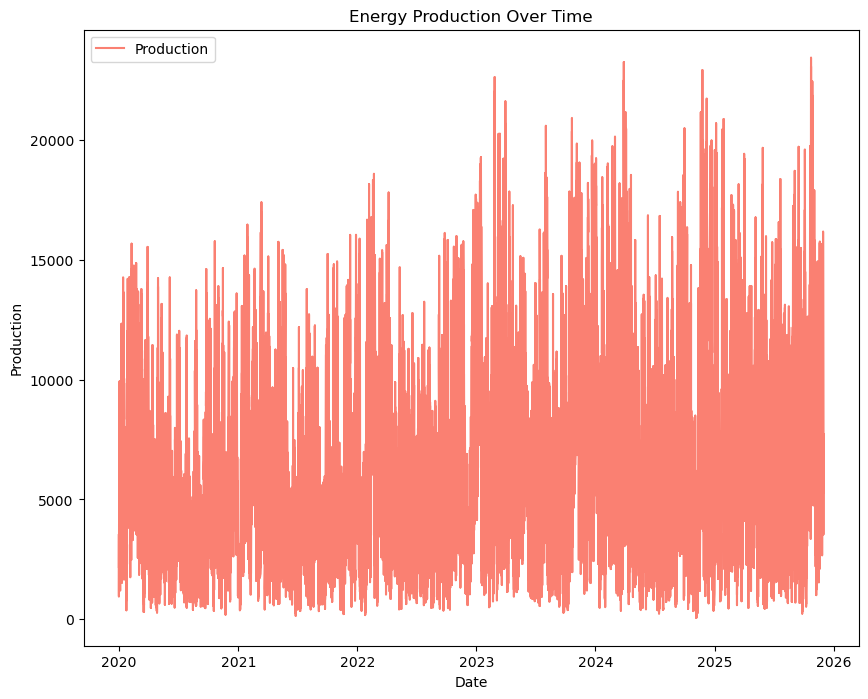

In [17]:
# to visualize target column.

fig, ax = plt.subplots(figsize =(10,8))
ax.plot(data.Date, data.Production, label="Production",color="salmon")

ax.set_title("Energy Production Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Production")
ax.legend()

plt.show()


negative_points = data[data.Production < 0]
ax.scatter(negative_points.Date,
           negative_points.Production,
           color="red",
           label="negative values",
           zorder=3
          );


Negative values in the target variable were checked, as energy production cannot be negative.  
Any such values are treated as potential data quality issues and are analyzed visually before deciding on corrective action in later stages.


### Histogram Of Production

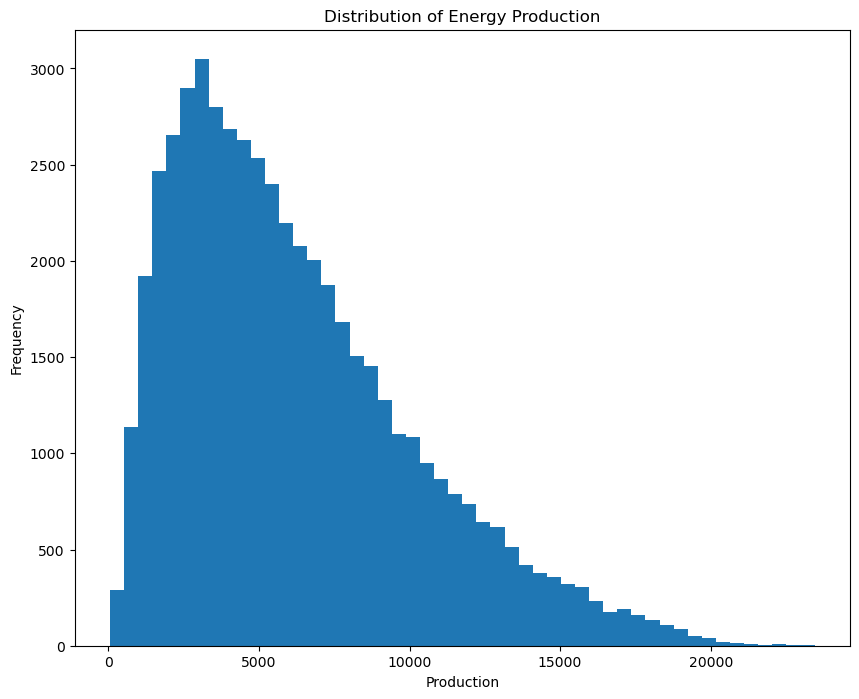

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.hist(data["Production"], bins=50)
ax.set_title("Distribution of Energy Production")
ax.set_xlabel("Production")
ax.set_ylabel("Frequency")

plt.show()


### Check for Hourly Pattern in the Data

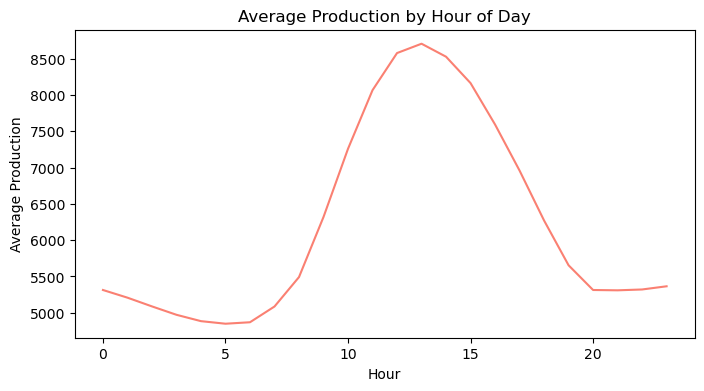

In [13]:
if "Start_Hour" in data.columns:
    hourly_avg = data.groupby("Start_Hour")["Production"].mean()

    plt.figure(figsize=(8,4))
    hourly_avg.plot(color="salmon")
    plt.title("Average Production by Hour of Day")
    plt.xlabel("Hour")
    plt.ylabel("Average Production")
    plt.show()

### Check for Seasonal/Categorical sanity

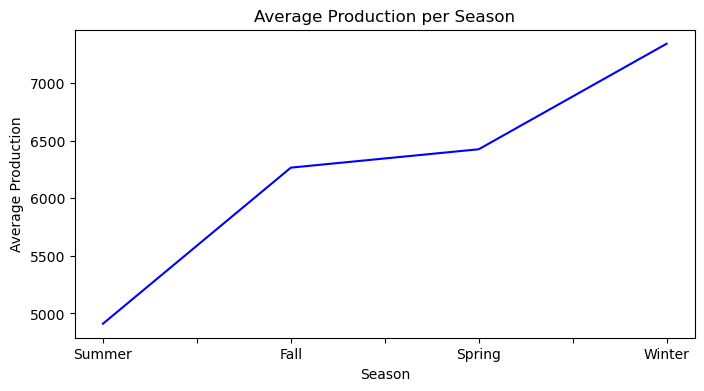

In [14]:
if "Season" in data.columns:
    seas_avg = data.groupby("Season")["Production"].mean().sort_values()

    plt.figure(figsize=(8,4))
    seas_avg.plot(color="blue")
    plt.title("Average Production per Season")
    plt.xlabel("Season")
    plt.ylabel("Average Production")
    plt.show()

### View production rates by month order

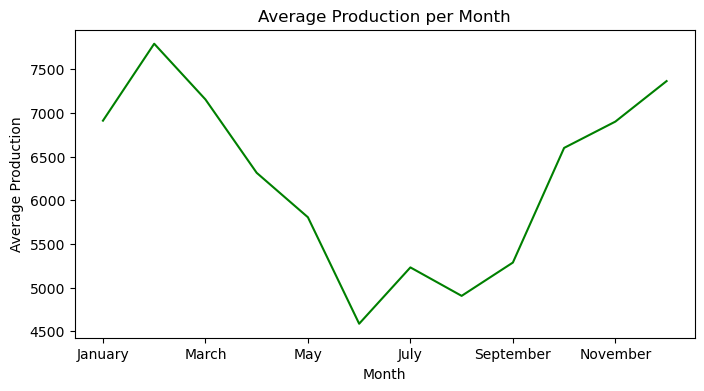

In [20]:
month_order = ["January","February","March","April","May","June","July","August","September","October","November","December"]

seas_avg = (
    data.groupby("Month_Name")["Production"]
    .mean()
    .reindex(month_order)
)

plt.figure(figsize=(8,4))
seas_avg.plot(color="green")
plt.title("Average Production per Month")
plt.xlabel("Month")
plt.ylabel("Average Production")
plt.show()


## Initial Observations

From exploratory analysis, we typically observe:
- strong hourly variation (peak vs off-peak)
- seasonal differences
- non-stationary behavior across months

These early observations guide:
- lag feature creation
- rolling statistics design
- error analysis strategy later in the project

---

## Phase 1 — Summary

In this phase, we validated the structural integrity and statistical behavior of the dataset before moving into modeling.

Key outcomes:

- ✔ Verified dataset shape and feature structure  
- ✔ Confirmed correct data types (especially `Date` as datetime)  
- ✔ Checked and handled missing values appropriately  
- ✔ Ensured chronological order (no shuffling, no leakage)  
- ✔ Explored target distribution and basic temporal patterns  
- ✔ Identified daily and seasonal production variability  

Most importantly, we confirmed that the dataset is **time-series structured and leakage-sensitive**, which directly influences how we split data and engineer features in the next phase.

With a clean and validated foundation, we are ready to proceed to **time-aware train/validation/test splitting**.
